In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

df = pd.read_csv("data/mcc18_test_data.csv")

df['Pi'] = df['Ii'] * df['Vi']
df['Po'] = df['Io'] * df['Vo']
df['Eff'] = df['Po'] / df['Pi']
df['Eff'] = df['Eff'].fillna(value=0)

print('Mean Eff:', df[1:]['Eff'].mean())

df

Mean Eff: 0.9258417569467561


,Vi,Ii,Vo,Io,Pcontrole,Pi,Po,Eff
0,0.076,0.009,0.073,0.000,0.945,0.000684,0.00000,0.000000
1,3.676,0.847,4.690,0.588,0.945,3.113572,2.75772,0.885709
2,10.090,2.425,13.420,1.680,0.945,24.468250,22.54560,0.921423
3,13.110,3.157,17.520,2.199,0.945,41.388270,38.52648,0.930855
4,14.720,3.557,19.750,2.472,0.945,52.359040,48.82200,0.932446
5,16.710,4.052,22.470,2.812,0.945,67.708920,63.18564,0.933195
6,18.850,4.583,25.480,3.176,0.945,86.389550,80.92448,0.936739
7,20.840,5.078,28.100,3.512,0.945,105.825520,98.68720,0.932546
8,23.030,5.611,31.060,3.883,0.945,129.221330,120.60598,0.933329
9,24.820,6.050,33.450,4.186,0.945,150.161000,140.02170,0.932477


[ 9.34665153e-01  1.69793545e-01 -1.56199844e-01  7.17453924e+02]


/tmp/ipykernel_3275/2415405763.py:8: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b/x) + c*np.exp(-d/x)


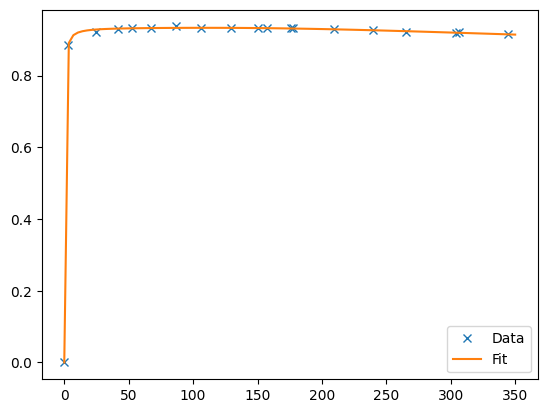

In [3]:
from scipy.optimize import curve_fit


# Define the function to use for curve fitting
def func(x, a, b, c, d):
    # Clipping because zero is a pole for this model
    x = x.clip(min=1e-6)
    return a*np.exp(-b/x) + c*np.exp(-d/x)


# Fit the curve to the data
popt, _ = curve_fit(func, df['Pi'].to_numpy(), df['Eff'].to_numpy())
print(popt)

pi = np.linspace(0, 350, 100)

# Plot the original data and the fitted curve
plt.plot(df['Pi'], df['Eff'], 'x', label='Data')
plt.plot(pi, func(pi, *popt), label='Fit')
plt.legend()
plt.show()

{0.0: 0.0, 4.040404040404041: 0.8962007482830393, 8.080808080808081: 0.9152309048992936, 12.121212121212121: 0.9216636684636083, 16.161616161616163: 0.9248969853574197, 20.202020202020204: 0.9268424175417572, 24.242424242424242: 0.9281416451504616, 28.282828282828284: 0.9290707797589286, 32.323232323232325: 0.9297682410280973, 36.36363636363637: 0.9303110725129525, 40.40404040404041: 0.930745563574853, 44.44444444444445: 0.9311011971245723, 48.484848484848484: 0.9313976291274028, 52.525252525252526: 0.9316484424345465, 56.56565656565657: 0.9318632836025772, 60.60606060606061: 0.9320491370525987, 64.64646464646465: 0.9322111164828274, 68.68686868686869: 0.9323529761677731, 72.72727272727273: 0.9324774550064384, 76.76767676767678: 0.9325865180866566, 80.80808080808082: 0.9326815336323878, 84.84848484848486: 0.9327634077242403, 88.8888888888889: 0.9328326901513351, 92.92929292929294: 0.9328896594665044, 96.96969696969697: 0.9329343922394913, 101.01010101010101: 0.9329668197286676, 105.050

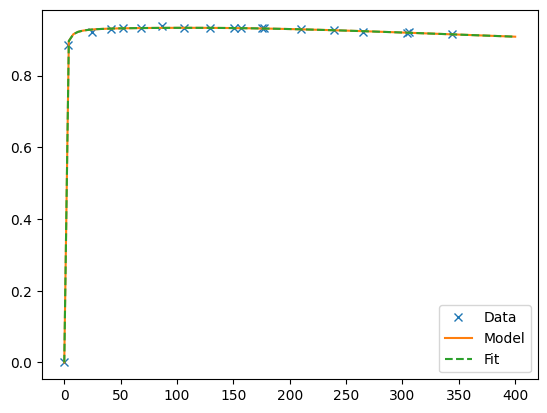

In [5]:
import bisect

def interpolate(lookup_table, value):
    sorted_keys = sorted(lookup_table.keys())

    # Check if value is below the lowest key
    if value < sorted_keys[0]:
        return lookup_table[sorted_keys[0]]

    # Check if value is above the highest key
    if value > sorted_keys[-1]:
        return lookup_table[sorted_keys[-1]]

    # Find the nearest lower and higher keys using bisect_left
    index = bisect.bisect_left(sorted_keys, value)
    if sorted_keys[index] == value:
        return lookup_table[value]

    low = sorted_keys[index - 1]
    high = sorted_keys[index]
    low_value = lookup_table[low]
    high_value = lookup_table[high]
    interpolation_ratio = (value - low) / (high - low)
    interpolated_value = low_value + (high_value - low_value) * interpolation_ratio
    return interpolated_value


pi = np.linspace(0, 400, 100)

# Use previous model
df2 = pd.DataFrame()
df2['Pi'] = pi
df2['Eff'] = func(pi, *popt)

# Create a LUT from previous model
eff_lut = {pi: eff for (pi,eff) in df2[['Pi', 'Eff']].to_numpy()}
eff = np.fromiter((interpolate(eff_lut, pi) for pi in pi), pi.dtype)
print(eff_lut)

# Plot the original data and the fitted curve
plt.plot(df['Pi'], df['Eff'], 'x', label='Data')
plt.plot(df2['Pi'], df2['Eff'], label='Model')
plt.plot(pi, eff, '--', label='Fit')
plt.legend()
plt.show()